<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Imports and Scripts

In [116]:
%%javascript
// ToC script
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [118]:
#Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')



In [1]:
# imports and constants
import json
import pickle
import datetime as dt

import gmaps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import multiprocessing
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

# user imports
import data_processing.analysis_utils as ls_utils

%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

## Display Constants

In [35]:
groups = ['all', 'no_symp', 'soc_anx', 'gen_anx', 'dep_anx']

# Load Data

In [36]:
gad_spin_corr = pd.read_pickle("wave1_features/all_gad_spin_gps_corr.df")
rev_gad_spin_corr = pd.read_pickle("wave1_features/all_rev_gad_spin_gps_corr.df")

phq_corr = pd.read_pickle("wave1_features/all_phq_gps_corr.df")
rev_phq_corr = pd.read_pickle("wave1_features/all_rev_phq_gps_corr.df")

In [37]:
rev_gad_spin_corr['gad_diff'] = rev_gad_spin_corr['gad_diff'].astype(float)

In [62]:
agg_cols_change = list(gad_spin_corr.columns[gad_spin_corr.columns.str.contains('change')])
sel_agg_cols = agg_cols_change

In [39]:
# gad_spin_corr = pd.read_pickle("wave1_features/all_gad_spin_corr_unit_log.df")
# rev_gad_spin_corr = pd.read_pickle("wave1_features/all_rev_gad_spin_corr_unit_log.df")

# phq_corr = pd.read_pickle("wave1_features/all_phq_corr_unit_log.df")
# rev_phq_corr = pd.read_pickle("wave1_features/all_rev_phq_corr_unit_log.df")

# Feature Unit Weight Definitions

## Fused Location (fus)


- "movement distance": 'velocity_total', 'dist_total'
- "movement duration": 'entropy_total', 'norm_entropy_total', 'circ_movt_tot'
- "movement variance": 'cluster_total', 'loc_var_total'

# Plots Over Time

### PHQ

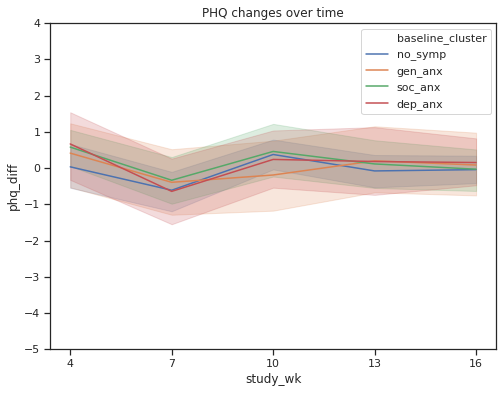

In [40]:
_, ax = plt.subplots(figsize=(8,6))
phq_corr['phq_start'] = pd.to_datetime(phq_corr['phq_start'])
g = sns.lineplot(x="study_wk", y="phq_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=phq_corr, ax=ax)
plt.xticks([4, 7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("PHQ changes over time")
plt.show()

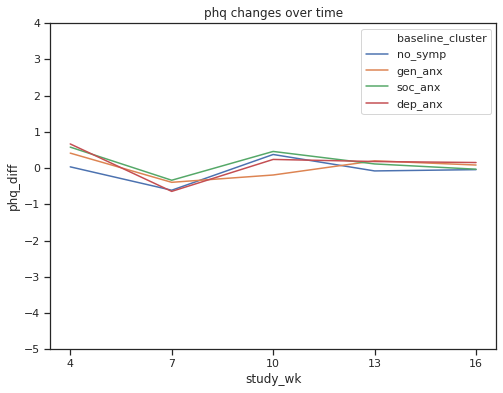

In [41]:
_, ax = plt.subplots(figsize=(8,6))
phq_corr['phq_start'] = pd.to_datetime(phq_corr['phq_start'])
g = sns.lineplot(x="study_wk", y="phq_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 data=phq_corr, ax=ax,
                 ci=None)
plt.xticks([4,7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("phq changes over time")
plt.show()

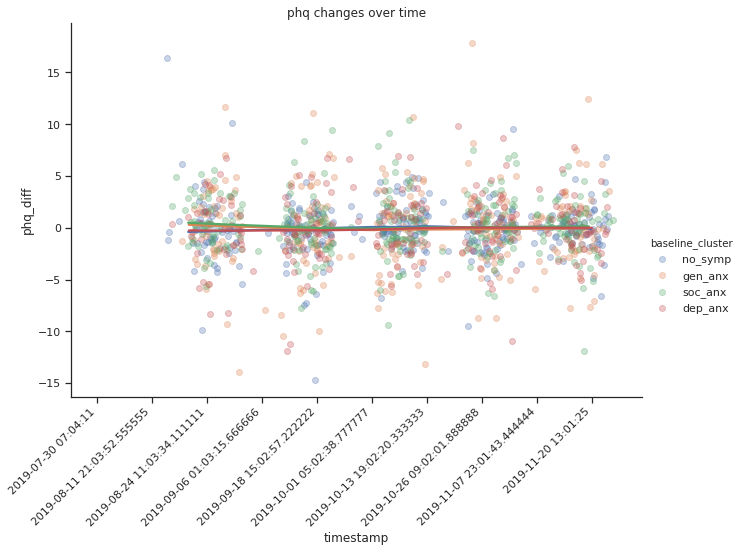

In [42]:
import matplotlib.dates as md

phq_corr['timestamp'] = (phq_corr['phq_start'] - dt.datetime(1970,1,1)).dt.total_seconds()


sns.lmplot(x='timestamp', y='phq_diff', 
           data=phq_corr, 
           lowess=True, 
           hue="baseline_cluster", 
           hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
           x_jitter=500000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.3
           },
           height=6,
           aspect=1.5
          )
ax=plt.gca()
ticks = np.linspace(phq_corr['timestamp'].min(), phq_corr['timestamp'].max(), 10)
idx = pd.date_range(phq_corr['phq_start'].min(), phq_corr['phq_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("phq changes over time")
plt.show()

In [43]:
train_cluster = pd.read_pickle("ls_data/train_cluster.df").to_frame()
test_cluster = pd.read_pickle("ls_data/test_cluster.df").to_frame()
cluster_df = train_cluster.append(test_cluster)
cluster_df = cluster_df.reset_index()

cluster_df['cluster'] = cluster_df['cluster'].map({
    0: 'no_symp',
    1: 'soc_anx',
    2: 'gen_anx',
    3: 'dep_anx'
})

cluster_dict = {k:v for k, v in zip(cluster_df['pid'].values, cluster_df['cluster'].values)}

Text(0.5, 1.0, 'Within individual PHQ shift variance')

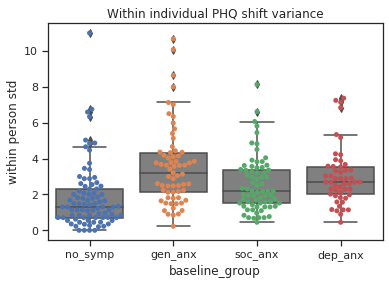

In [44]:

phq_std = phq_corr.groupby('pid')['phq_diff'].std()
phq_std = phq_std.to_frame().reset_index()
phq_std['baseline_group'] = phq_std['pid'].map(cluster_dict)
phq_std = phq_std.rename(columns={'phq_diff': 'within person std'})


ax = sns.swarmplot(x="baseline_group", y='within person std', data=phq_std,
                   #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'])
                   order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'])
ax = sns.boxplot(x="baseline_group", y='within person std', data=phq_std, 
                 #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'], 
                 color=".5")
plt.title("Within individual PHQ shift variance")

In [45]:
phq_std.describe()

,within person std
count,272.000000
mean,2.658047
std,1.904565
min,0.000000
25%,1.303840
50%,2.236068
75%,3.563706
max,11.000000


In [46]:
phq_std.groupby('baseline_group').describe()

within person std                                          \
                           count      mean       std       min       25%   
baseline_group                                                             
dep_anx                     51.0  2.993774  1.597988  0.447214  1.999905   
gen_anx                     65.0  3.547788  2.176730  0.223607  2.121320   
no_symp                     86.0  1.847536  1.798082  0.000000  0.707107   
soc_anx                     70.0  2.583030  1.537872  0.447214  1.516575   

                                               
                     50%       75%        max  
baseline_group                                 
dep_anx         2.687419  3.549620   7.368853  
gen_anx         3.213254  4.335897  10.677078  
no_symp         1.322741  2.306240  11.000000  
soc_anx         2.190890  3.386217   8.136338

### SPIN

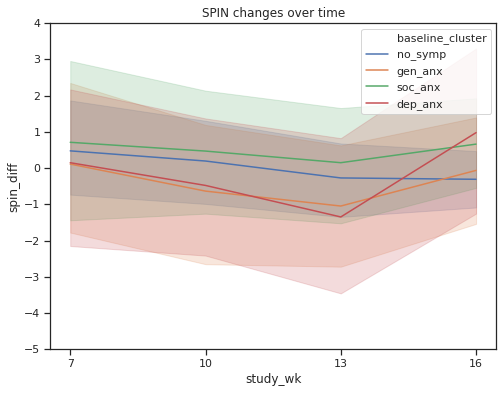

In [47]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['spin_start'] = pd.to_datetime(gad_spin_corr['spin_start'])
g = sns.lineplot(x="study_wk", y="spin_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=gad_spin_corr, ax=ax)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("SPIN changes over time")
plt.show()

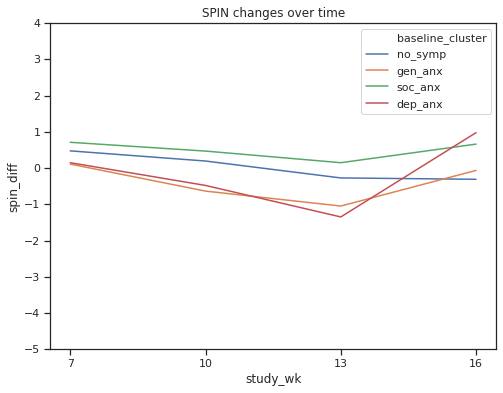

In [48]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['spin_start'] = pd.to_datetime(gad_spin_corr['spin_start'])
g = sns.lineplot(x="study_wk", y="spin_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 data=gad_spin_corr, ax=ax,
                 ci=None)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("SPIN changes over time")
plt.show()

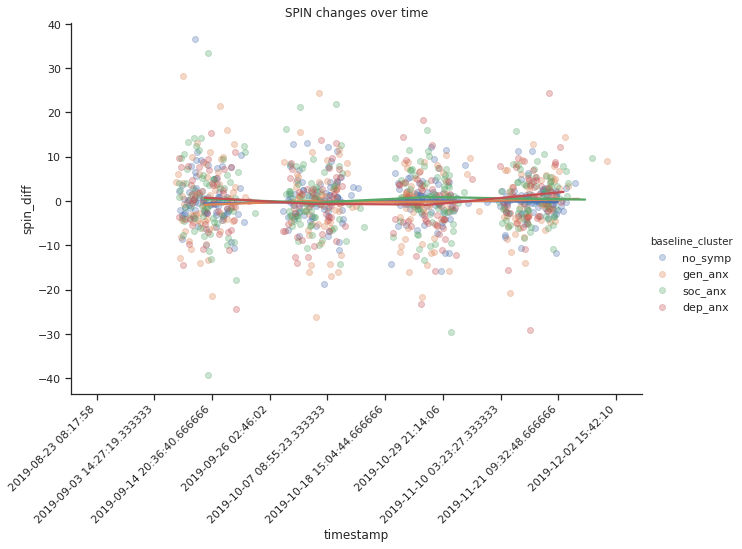

In [49]:
import matplotlib.dates as md

gad_spin_corr['timestamp'] = (gad_spin_corr['spin_start'] - dt.datetime(1970,1,1)).dt.total_seconds()

sns.lmplot(x='timestamp', y='spin_diff', 
           data=gad_spin_corr, 
           lowess=True, 
           hue="baseline_cluster", 
           hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
           x_jitter=500000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.3
           },
           height=6,
           aspect=1.5
          )
ax=plt.gca()
ticks = np.linspace(gad_spin_corr['timestamp'].min(), gad_spin_corr['timestamp'].max(), 10)
idx = pd.date_range(gad_spin_corr['spin_start'].min(), gad_spin_corr['spin_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("SPIN changes over time")
plt.show()

Text(0.5, 1.0, 'Within individual SPIN shift variance')

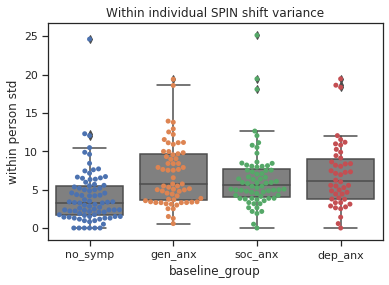

In [50]:

spin_std = gad_spin_corr.groupby('pid')['spin_diff'].std()
spin_std = spin_std.to_frame().reset_index()
spin_std['baseline_group'] = spin_std['pid'].map(cluster_dict)
spin_std = spin_std.rename(columns={'spin_diff': 'within person std'})


ax = sns.swarmplot(x="baseline_group", y='within person std', data=spin_std,
                   #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'])
                   order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'])
ax = sns.boxplot(x="baseline_group", y='within person std', data=spin_std, 
                 #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'], 
                 color=".5")
plt.title("Within individual SPIN shift variance")

In [51]:
spin_std.describe()

,within person std
count,259.000000
mean,5.899790
std,4.163573
min,0.000000
25%,3.214132
50%,4.991660
75%,7.892507
max,25.118055


In [52]:
spin_std.groupby('baseline_group').describe()

within person std                                         \
                           count      mean       std      min       25%   
baseline_group                                                            
dep_anx                     46.0  6.969471  4.364506  0.00000  3.810133   
gen_anx                     63.0  6.981505  4.027708  0.57735  3.622292   
no_symp                     82.0  4.024435  3.620225  0.00000  1.657758   
soc_anx                     68.0  6.435462  4.077029  0.00000  4.052987   

                                               
                     50%       75%        max  
baseline_group                                 
dep_anx         6.129560  9.000743  19.433648  
gen_anx         5.737305  9.617501  19.379972  
no_symp         3.265986  5.469209  24.608603  
soc_anx         5.624505  7.642549  25.118055

### GAD

In [53]:
gad_spin_corr['gad_diff'] = gad_spin_corr['gad_diff'].astype(float)

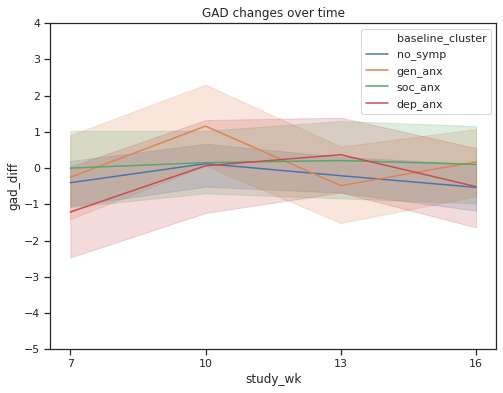

In [54]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['gad_start'] = pd.to_datetime(gad_spin_corr['gad_start'])
g = sns.lineplot(x="study_wk", y="gad_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=gad_spin_corr, ax=ax)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("GAD changes over time")
plt.show()

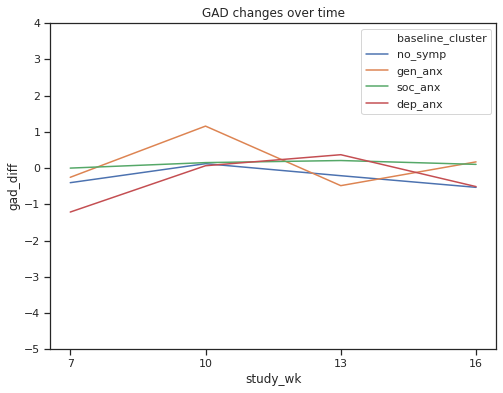

In [55]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['gad_start'] = pd.to_datetime(gad_spin_corr['gad_start'])
g = sns.lineplot(x="study_wk", y="gad_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 data=gad_spin_corr, ax=ax,
                 ci=None)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("GAD changes over time")
plt.show()

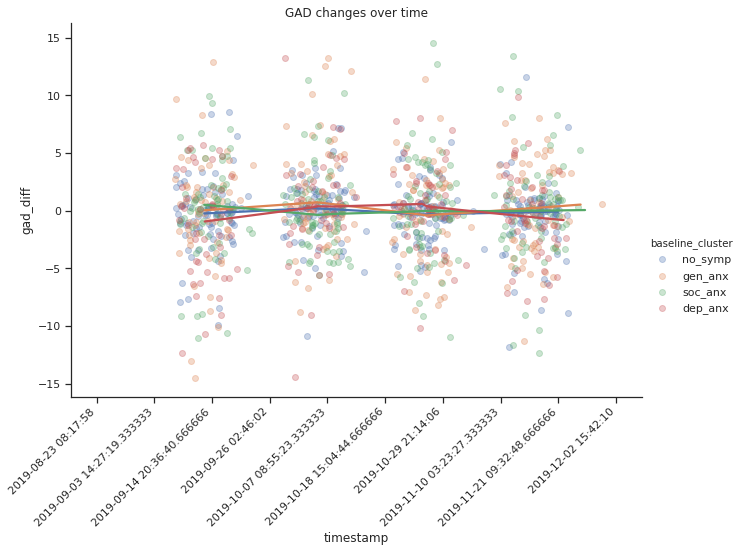

In [56]:
import matplotlib.dates as md

gad_spin_corr['timestamp'] = (gad_spin_corr['gad_start'] - dt.datetime(1970,1,1)).dt.total_seconds()

sns.lmplot(x='timestamp', y='gad_diff', 
           data=gad_spin_corr, 
           lowess=True, 
           hue="baseline_cluster", 
           hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
           x_jitter=500000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.3
           },
           height=6,
           aspect=1.5
          )
ax=plt.gca()
ticks = np.linspace(gad_spin_corr['timestamp'].min(), gad_spin_corr['timestamp'].max(), 10)
idx = pd.date_range(gad_spin_corr['spin_start'].min(), gad_spin_corr['spin_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("GAD changes over time")
plt.show()

Text(0.5, 1.0, 'Within individual gad shift variance')

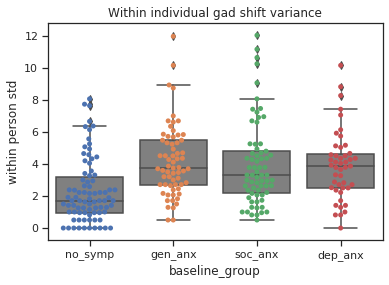

In [57]:

gad_std = gad_spin_corr.groupby('pid')['gad_diff'].std()
gad_std = gad_std.to_frame().reset_index()
gad_std['baseline_group'] = gad_std['pid'].map(cluster_dict)
gad_std = gad_std.rename(columns={'gad_diff': 'within person std'})


ax = sns.swarmplot(x="baseline_group", y='within person std', data=gad_std,
                   #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'])
                   order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'])
ax = sns.boxplot(x="baseline_group", y='within person std', data=gad_std, 
                 #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'], 
                 color=".5")
plt.title("Within individual gad shift variance")

In [58]:
gad_std.describe()

,within person std
count,260.000000
mean,3.501206
std,2.382952
min,0.000000
25%,1.707825
50%,3.054563
75%,4.654747
max,12.020815


In [59]:
gad_std.groupby('baseline_group').describe()

within person std                                               \
                           count      mean       std  min       25%       50%   
baseline_group                                                                  
dep_anx                     46.0  3.907512  2.145929  0.0  2.504153  3.888995   
gen_anx                     64.0  4.192597  2.211141  0.5  2.708013  3.758287   
no_symp                     82.0  2.328305  1.999417  0.0  0.968070  1.707825   
soc_anx                     68.0  3.990012  2.632820  0.5  2.203079  3.304038   

                                     
                     75%        max  
baseline_group                       
dep_anx         4.634429  10.144785  
gen_anx         5.477226  11.954776  
no_symp         3.199490   8.057088  
soc_anx         4.830094  12.020815

# SPIN

## Full population

In [63]:
ls_utils.display_all_corr(gad_spin_corr, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(gad_spin_corr, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,spin_diff,1012,-0.006,0.8549,0.9326,fdr_bh
1,movt_variance_agg_change,spin_diff,1012,0.008,0.7889,0.9326,fdr_bh
2,movt_duration_agg_change,spin_diff,1012,0.032,0.3133,0.7731,fdr_bh
3,cluster_total_change,spin_diff,1012,0.029,0.3485,0.7731,fdr_bh
4,cluster_wkday_change,spin_diff,1011,0.015,0.6419,0.8595,fdr_bh
5,cluster_wkend_change,spin_diff,963,0.023,0.4670,0.7731,fdr_bh
6,dist_total_change,spin_diff,1012,0.02,0.5154,0.7731,fdr_bh
7,dist_wkday_change,spin_diff,1011,0.015,0.6446,0.8595,fdr_bh
8,dist_wkend_change,spin_diff,963,0.021,0.5123,0.7731,fdr_bh
9,entropy_total_change,spin_diff,1012,0.059,0.0607*,0.5461,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,spin_diff,1012,-0.003,0.9135,0.9135,fdr_bh
1,movt_variance_agg_change,spin_diff,1012,0.034,0.2844,0.8531,fdr_bh
2,movt_duration_agg_change,spin_diff,1012,0.068,0.0304*,0.2433,fdr_bh
3,cluster_total_change,spin_diff,1012,0.048,0.1240,0.5950,fdr_bh
4,cluster_wkday_change,spin_diff,1011,0.028,0.3759,0.9135,fdr_bh
5,cluster_wkend_change,spin_diff,963,0.021,0.5192,0.9135,fdr_bh
6,dist_total_change,spin_diff,1012,-0.004,0.9076,0.9135,fdr_bh
7,dist_wkday_change,spin_diff,1011,-0.009,0.7748,0.9135,fdr_bh
8,dist_wkend_change,spin_diff,963,-0.009,0.7770,0.9135,fdr_bh
9,entropy_total_change,spin_diff,1012,0.084,0.0072*,0.1732,fdr_bh


## no_symp

In [64]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,spin_diff,320,-0.052,0.3575,0.9539,fdr_bh
1,movt_variance_agg_change,spin_diff,320,-0.017,0.7552,0.9539,fdr_bh
2,movt_duration_agg_change,spin_diff,320,0.024,0.6736,0.9539,fdr_bh
3,cluster_total_change,spin_diff,320,-0.031,0.5766,0.9539,fdr_bh
4,cluster_wkday_change,spin_diff,320,-0.063,0.2626,0.9539,fdr_bh
5,cluster_wkend_change,spin_diff,302,0.036,0.5379,0.9539,fdr_bh
6,dist_total_change,spin_diff,320,-0.007,0.9036,0.9646,fdr_bh
7,dist_wkday_change,spin_diff,320,-0.02,0.7157,0.9539,fdr_bh
8,dist_wkend_change,spin_diff,302,0.024,0.6840,0.9539,fdr_bh
9,entropy_total_change,spin_diff,320,0.039,0.4855,0.9539,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,spin_diff,320,0.017,0.7681,0.9473,fdr_bh
1,movt_variance_agg_change,spin_diff,320,0.043,0.4468,0.9473,fdr_bh
2,movt_duration_agg_change,spin_diff,320,0.057,0.3069,0.9473,fdr_bh
3,cluster_total_change,spin_diff,320,0.037,0.5095,0.9473,fdr_bh
4,cluster_wkday_change,spin_diff,320,-0.01,0.8596,0.9473,fdr_bh
5,cluster_wkend_change,spin_diff,302,0.039,0.4958,0.9473,fdr_bh
6,dist_total_change,spin_diff,320,0.03,0.5950,0.9473,fdr_bh
7,dist_wkday_change,spin_diff,320,0.044,0.4287,0.9473,fdr_bh
8,dist_wkend_change,spin_diff,302,-0.002,0.9777,0.9777,fdr_bh
9,entropy_total_change,spin_diff,320,0.059,0.2913,0.9473,fdr_bh


## soc_anx

In [65]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,spin_diff,266,0.093,0.1321,0.7929,fdr_bh
1,movt_variance_agg_change,spin_diff,266,-0.014,0.8215,0.9600,fdr_bh
2,movt_duration_agg_change,spin_diff,266,-0.043,0.4869,0.8765,fdr_bh
3,cluster_total_change,spin_diff,266,0.046,0.4586,0.8765,fdr_bh
4,cluster_wkday_change,spin_diff,266,0.026,0.6761,0.8765,fdr_bh
5,cluster_wkend_change,spin_diff,256,0.009,0.8838,0.9600,fdr_bh
6,dist_total_change,spin_diff,266,0.109,0.0765*,0.7929,fdr_bh
7,dist_wkday_change,spin_diff,266,0.117,0.0568*,0.7929,fdr_bh
8,dist_wkend_change,spin_diff,256,0.007,0.9175,0.9600,fdr_bh
9,entropy_total_change,spin_diff,266,0.024,0.6939,0.8765,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,spin_diff,266,-0.041,0.5008,0.7513,fdr_bh
1,movt_variance_agg_change,spin_diff,266,0,0.9952,0.9952,fdr_bh
2,movt_duration_agg_change,spin_diff,266,-0.057,0.3508,0.7016,fdr_bh
3,cluster_total_change,spin_diff,266,0.064,0.2996,0.6536,fdr_bh
4,cluster_wkday_change,spin_diff,266,0.049,0.4299,0.7057,fdr_bh
5,cluster_wkend_change,spin_diff,256,0.019,0.7616,0.9276,fdr_bh
6,dist_total_change,spin_diff,266,-0.066,0.2851,0.6536,fdr_bh
7,dist_wkday_change,spin_diff,266,-0.03,0.6313,0.8584,fdr_bh
8,dist_wkend_change,spin_diff,256,-0.087,0.1653,0.6536,fdr_bh
9,entropy_total_change,spin_diff,266,0.011,0.8520,0.9276,fdr_bh


## gen_anx

In [67]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,spin_diff,251,0.018,0.7763,0.8872,fdr_bh
1,movt_variance_agg_change,spin_diff,251,0.05,0.4334,0.6935,fdr_bh
2,movt_duration_agg_change,spin_diff,251,0.091,0.1513,0.4777,fdr_bh
3,cluster_total_change,spin_diff,251,0.077,0.2212,0.5636,fdr_bh
4,cluster_wkday_change,spin_diff,251,0.116,0.0654*,0.3139,fdr_bh
5,cluster_wkend_change,spin_diff,242,-0.033,0.6126,0.8077,fdr_bh
6,dist_total_change,spin_diff,251,0.026,0.6824,0.8188,fdr_bh
7,dist_wkday_change,spin_diff,251,-0.046,0.4722,0.7084,fdr_bh
8,dist_wkend_change,spin_diff,242,0.074,0.2547,0.5636,fdr_bh
9,entropy_total_change,spin_diff,251,0.12,0.0585*,0.3139,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,spin_diff,251,0.028,0.6633,0.7960,fdr_bh
1,movt_variance_agg_change,spin_diff,251,0.059,0.3530,0.5501,fdr_bh
2,movt_duration_agg_change,spin_diff,251,0.119,0.0604*,0.3495,fdr_bh
3,cluster_total_change,spin_diff,251,0.08,0.2071,0.5501,fdr_bh
4,cluster_wkday_change,spin_diff,251,0.128,0.0433*,0.3462,fdr_bh
5,cluster_wkend_change,spin_diff,242,-0.077,0.2357,0.5501,fdr_bh
6,dist_total_change,spin_diff,251,0.019,0.7616,0.8704,fdr_bh
7,dist_wkday_change,spin_diff,251,0.001,0.9876,0.9876,fdr_bh
8,dist_wkend_change,spin_diff,242,0.065,0.3150,0.5501,fdr_bh
9,entropy_total_change,spin_diff,251,0.133,0.0351*,0.3462,fdr_bh


## dep_anx

In [68]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,spin_diff,175,-0.036,0.6346,0.9413,fdr_bh
1,movt_variance_agg_change,spin_diff,175,0.025,0.7443,0.9413,fdr_bh
2,movt_duration_agg_change,spin_diff,175,0.047,0.5408,0.9413,fdr_bh
3,cluster_total_change,spin_diff,175,0.023,0.7599,0.9413,fdr_bh
4,cluster_wkday_change,spin_diff,174,-0.036,0.6394,0.9413,fdr_bh
5,cluster_wkend_change,spin_diff,163,0.106,0.1784,0.9413,fdr_bh
6,dist_total_change,spin_diff,175,-0.037,0.6260,0.9413,fdr_bh
7,dist_wkday_change,spin_diff,174,-0.047,0.5339,0.9413,fdr_bh
8,dist_wkend_change,spin_diff,163,-0.006,0.9376,0.9941,fdr_bh
9,entropy_total_change,spin_diff,175,0.044,0.5656,0.9413,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,spin_diff,175,-0.016,0.8285,0.9879,fdr_bh
1,movt_variance_agg_change,spin_diff,175,0.038,0.6217,0.9879,fdr_bh
2,movt_duration_agg_change,spin_diff,175,0.151,0.0463*,0.5656,fdr_bh
3,cluster_total_change,spin_diff,175,0.012,0.8699,0.9879,fdr_bh
4,cluster_wkday_change,spin_diff,174,-0.077,0.3097,0.7027,fdr_bh
5,cluster_wkend_change,spin_diff,163,0.125,0.1113,0.5656,fdr_bh
6,dist_total_change,spin_diff,175,-0.001,0.9942,0.9942,fdr_bh
7,dist_wkday_change,spin_diff,174,-0.064,0.4037,0.7454,fdr_bh
8,dist_wkend_change,spin_diff,163,0.006,0.9365,0.9879,fdr_bh
9,entropy_total_change,spin_diff,175,0.139,0.0669*,0.5656,fdr_bh


# Reverse SPIN

## Full population

In [69]:
ls_utils.display_all_corr(rev_gad_spin_corr, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_gad_spin_corr, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,spin_diff,1012,-0.006,0.8549,0.8921,fdr_bh
1,movt_variance_agg_change,spin_diff,1012,0.008,0.7889,0.8921,fdr_bh
2,movt_duration_agg_change,spin_diff,1019,0.064,0.0423*,0.4096,fdr_bh
3,cluster_total_change,spin_diff,1012,0.029,0.3485,0.7276,fdr_bh
4,cluster_wkday_change,spin_diff,1011,0.015,0.6419,0.8143,fdr_bh
5,cluster_wkend_change,spin_diff,963,0.023,0.4670,0.7276,fdr_bh
6,dist_total_change,spin_diff,1012,0.02,0.5154,0.7276,fdr_bh
7,dist_wkday_change,spin_diff,1011,0.015,0.6446,0.8143,fdr_bh
8,dist_wkend_change,spin_diff,963,0.021,0.5123,0.7276,fdr_bh
9,entropy_total_change,spin_diff,1012,0.059,0.0607*,0.4096,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,spin_diff,1012,-0.003,0.9135,0.9135,fdr_bh
1,movt_variance_agg_change,spin_diff,1012,0.034,0.2844,0.6825,fdr_bh
2,movt_duration_agg_change,spin_diff,1019,0.087,0.0057*,0.0866*,fdr_bh
3,cluster_total_change,spin_diff,1012,0.048,0.1240,0.4250,fdr_bh
4,cluster_wkday_change,spin_diff,1011,0.028,0.3759,0.7722,fdr_bh
5,cluster_wkend_change,spin_diff,963,0.021,0.5192,0.9135,fdr_bh
6,dist_total_change,spin_diff,1012,-0.004,0.9076,0.9135,fdr_bh
7,dist_wkday_change,spin_diff,1011,-0.009,0.7748,0.9135,fdr_bh
8,dist_wkend_change,spin_diff,963,-0.009,0.7770,0.9135,fdr_bh
9,entropy_total_change,spin_diff,1012,0.084,0.0072*,0.0866*,fdr_bh


## no_symp

In [70]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,spin_diff,320,-0.052,0.3575,0.8359,fdr_bh
1,movt_variance_agg_change,spin_diff,320,-0.017,0.7552,0.9062,fdr_bh
2,movt_duration_agg_change,spin_diff,325,0.065,0.2427,0.8359,fdr_bh
3,cluster_total_change,spin_diff,320,-0.031,0.5766,0.8359,fdr_bh
4,cluster_wkday_change,spin_diff,320,-0.063,0.2626,0.8359,fdr_bh
5,cluster_wkend_change,spin_diff,302,0.036,0.5379,0.8359,fdr_bh
6,dist_total_change,spin_diff,320,-0.007,0.9036,0.9646,fdr_bh
7,dist_wkday_change,spin_diff,320,-0.02,0.7157,0.9040,fdr_bh
8,dist_wkend_change,spin_diff,302,0.024,0.6840,0.9040,fdr_bh
9,entropy_total_change,spin_diff,320,0.039,0.4855,0.8359,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,spin_diff,320,0.017,0.7681,0.9889,fdr_bh
1,movt_variance_agg_change,spin_diff,320,0.043,0.4468,0.9889,fdr_bh
2,movt_duration_agg_change,spin_diff,325,0.071,0.1994,0.9889,fdr_bh
3,cluster_total_change,spin_diff,320,0.037,0.5095,0.9889,fdr_bh
4,cluster_wkday_change,spin_diff,320,-0.01,0.8596,0.9889,fdr_bh
5,cluster_wkend_change,spin_diff,302,0.039,0.4958,0.9889,fdr_bh
6,dist_total_change,spin_diff,320,0.03,0.5950,0.9889,fdr_bh
7,dist_wkday_change,spin_diff,320,0.044,0.4287,0.9889,fdr_bh
8,dist_wkend_change,spin_diff,302,-0.002,0.9777,0.9889,fdr_bh
9,entropy_total_change,spin_diff,320,0.059,0.2913,0.9889,fdr_bh


## soc_anx

In [71]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,spin_diff,266,0.093,0.1321,0.8467,fdr_bh
1,movt_variance_agg_change,spin_diff,266,-0.014,0.8215,0.9976,fdr_bh
2,movt_duration_agg_change,spin_diff,267,0.057,0.3528,0.8467,fdr_bh
3,cluster_total_change,spin_diff,266,0.046,0.4586,0.8911,fdr_bh
4,cluster_wkday_change,spin_diff,266,0.026,0.6761,0.9252,fdr_bh
5,cluster_wkend_change,spin_diff,256,0.009,0.8838,0.9976,fdr_bh
6,dist_total_change,spin_diff,266,0.109,0.0765*,0.8467,fdr_bh
7,dist_wkday_change,spin_diff,266,0.117,0.0568*,0.8467,fdr_bh
8,dist_wkend_change,spin_diff,256,0.007,0.9175,0.9976,fdr_bh
9,entropy_total_change,spin_diff,266,0.024,0.6939,0.9252,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,spin_diff,266,-0.041,0.5008,0.8013,fdr_bh
1,movt_variance_agg_change,spin_diff,266,0,0.9952,0.9952,fdr_bh
2,movt_duration_agg_change,spin_diff,267,0.057,0.3550,0.7562,fdr_bh
3,cluster_total_change,spin_diff,266,0.064,0.2996,0.7190,fdr_bh
4,cluster_wkday_change,spin_diff,266,0.049,0.4299,0.7562,fdr_bh
5,cluster_wkend_change,spin_diff,256,0.019,0.7616,0.9698,fdr_bh
6,dist_total_change,spin_diff,266,-0.066,0.2851,0.7190,fdr_bh
7,dist_wkday_change,spin_diff,266,-0.03,0.6313,0.9089,fdr_bh
8,dist_wkend_change,spin_diff,256,-0.087,0.1653,0.6857,fdr_bh
9,entropy_total_change,spin_diff,266,0.011,0.8520,0.9698,fdr_bh


## gen_anx

In [72]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,spin_diff,251,0.018,0.7763,0.9280,fdr_bh
1,movt_variance_agg_change,spin_diff,251,0.05,0.4334,0.8002,fdr_bh
2,movt_duration_agg_change,spin_diff,252,0.105,0.0954*,0.3814,fdr_bh
3,cluster_total_change,spin_diff,251,0.077,0.2212,0.5898,fdr_bh
4,cluster_wkday_change,spin_diff,251,0.116,0.0654*,0.3139,fdr_bh
5,cluster_wkend_change,spin_diff,242,-0.033,0.6126,0.8619,fdr_bh
6,dist_total_change,spin_diff,251,0.026,0.6824,0.8619,fdr_bh
7,dist_wkday_change,spin_diff,251,-0.046,0.4722,0.8073,fdr_bh
8,dist_wkend_change,spin_diff,242,0.074,0.2547,0.6113,fdr_bh
9,entropy_total_change,spin_diff,251,0.12,0.0585*,0.3139,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,spin_diff,251,0.028,0.6633,0.9365,fdr_bh
1,movt_variance_agg_change,spin_diff,251,0.059,0.3530,0.6516,fdr_bh
2,movt_duration_agg_change,spin_diff,252,0.115,0.0686*,0.3495,fdr_bh
3,cluster_total_change,spin_diff,251,0.08,0.2071,0.6213,fdr_bh
4,cluster_wkday_change,spin_diff,251,0.128,0.0433*,0.3462,fdr_bh
5,cluster_wkend_change,spin_diff,242,-0.077,0.2357,0.6286,fdr_bh
6,dist_total_change,spin_diff,251,0.019,0.7616,0.9876,fdr_bh
7,dist_wkday_change,spin_diff,251,0.001,0.9876,0.9876,fdr_bh
8,dist_wkend_change,spin_diff,242,0.065,0.3150,0.6516,fdr_bh
9,entropy_total_change,spin_diff,251,0.133,0.0351*,0.3462,fdr_bh


## dep_anx

In [73]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,spin_diff,175,-0.036,0.6346,0.9413,fdr_bh
1,movt_variance_agg_change,spin_diff,175,0.025,0.7443,0.9413,fdr_bh
2,movt_duration_agg_change,spin_diff,175,0.022,0.7740,0.9413,fdr_bh
3,cluster_total_change,spin_diff,175,0.023,0.7599,0.9413,fdr_bh
4,cluster_wkday_change,spin_diff,174,-0.036,0.6394,0.9413,fdr_bh
5,cluster_wkend_change,spin_diff,163,0.106,0.1784,0.9413,fdr_bh
6,dist_total_change,spin_diff,175,-0.037,0.6260,0.9413,fdr_bh
7,dist_wkday_change,spin_diff,174,-0.047,0.5339,0.9413,fdr_bh
8,dist_wkend_change,spin_diff,163,-0.006,0.9376,0.9941,fdr_bh
9,entropy_total_change,spin_diff,175,0.044,0.5656,0.9413,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,spin_diff,175,-0.016,0.8285,0.9942,fdr_bh
1,movt_variance_agg_change,spin_diff,175,0.038,0.6217,0.9942,fdr_bh
2,movt_duration_agg_change,spin_diff,175,0.123,0.1055,0.5656,fdr_bh
3,cluster_total_change,spin_diff,175,0.012,0.8699,0.9942,fdr_bh
4,cluster_wkday_change,spin_diff,174,-0.077,0.3097,0.8258,fdr_bh
5,cluster_wkend_change,spin_diff,163,0.125,0.1113,0.5656,fdr_bh
6,dist_total_change,spin_diff,175,-0.001,0.9942,0.9942,fdr_bh
7,dist_wkday_change,spin_diff,174,-0.064,0.4037,0.9690,fdr_bh
8,dist_wkend_change,spin_diff,163,0.006,0.9365,0.9942,fdr_bh
9,entropy_total_change,spin_diff,175,0.139,0.0669*,0.5656,fdr_bh


# GAD

## Full population

In [74]:
ls_utils.display_all_corr(gad_spin_corr, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(gad_spin_corr, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,gad_diff,1013,-0.068,0.0311*,0.1788,fdr_bh
1,movt_variance_agg_change,gad_diff,1013,-0.056,0.0745*,0.1788,fdr_bh
2,movt_duration_agg_change,gad_diff,1013,-0.013,0.6876,0.6876,fdr_bh
3,cluster_total_change,gad_diff,1013,-0.058,0.0643*,0.1788,fdr_bh
4,cluster_wkday_change,gad_diff,1012,-0.041,0.1889,0.2666,fdr_bh
5,cluster_wkend_change,gad_diff,964,-0.058,0.0741*,0.1788,fdr_bh
6,dist_total_change,gad_diff,1013,-0.064,0.0411*,0.1788,fdr_bh
7,dist_wkday_change,gad_diff,1012,-0.055,0.0824*,0.1798,fdr_bh
8,dist_wkend_change,gad_diff,964,-0.08,0.0133*,0.1788,fdr_bh
9,entropy_total_change,gad_diff,1013,0.014,0.6582,0.6868,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,gad_diff,1013,-0.018,0.5687,0.9694,fdr_bh
1,movt_variance_agg_change,gad_diff,1013,-0.018,0.5620,0.9694,fdr_bh
2,movt_duration_agg_change,gad_diff,1013,0.002,0.9469,0.9694,fdr_bh
3,cluster_total_change,gad_diff,1013,-0.012,0.6950,0.9694,fdr_bh
4,cluster_wkday_change,gad_diff,1012,-0.008,0.7899,0.9694,fdr_bh
5,cluster_wkend_change,gad_diff,964,-0.047,0.1428,0.9694,fdr_bh
6,dist_total_change,gad_diff,1013,-0.022,0.4841,0.9694,fdr_bh
7,dist_wkday_change,gad_diff,1012,-0.008,0.7922,0.9694,fdr_bh
8,dist_wkend_change,gad_diff,964,-0.03,0.3474,0.9694,fdr_bh
9,entropy_total_change,gad_diff,1013,0.014,0.6602,0.9694,fdr_bh


## no_symp

In [75]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,gad_diff,320,-0.117,0.0372*,0.2977,fdr_bh
1,movt_variance_agg_change,gad_diff,320,-0.046,0.4106,0.6570,fdr_bh
2,movt_duration_agg_change,gad_diff,320,0.021,0.7033,0.7338,fdr_bh
3,cluster_total_change,gad_diff,320,-0.025,0.6575,0.7222,fdr_bh
4,cluster_wkday_change,gad_diff,320,-0.025,0.6616,0.7222,fdr_bh
5,cluster_wkend_change,gad_diff,302,-0.068,0.2401,0.4433,fdr_bh
6,dist_total_change,gad_diff,320,-0.129,0.0214*,0.2977,fdr_bh
7,dist_wkday_change,gad_diff,320,-0.108,0.0533*,0.3198,fdr_bh
8,dist_wkend_change,gad_diff,302,-0.122,0.0337*,0.2977,fdr_bh
9,entropy_total_change,gad_diff,320,0.077,0.1707,0.3725,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,gad_diff,320,0.027,0.6269,0.9816,fdr_bh
1,movt_variance_agg_change,gad_diff,320,0.025,0.6616,0.9816,fdr_bh
2,movt_duration_agg_change,gad_diff,320,0.012,0.8267,0.9816,fdr_bh
3,cluster_total_change,gad_diff,320,0.01,0.8612,0.9816,fdr_bh
4,cluster_wkday_change,gad_diff,320,-0.004,0.9454,0.9816,fdr_bh
5,cluster_wkend_change,gad_diff,302,-0.073,0.2064,0.9816,fdr_bh
6,dist_total_change,gad_diff,320,0.026,0.6421,0.9816,fdr_bh
7,dist_wkday_change,gad_diff,320,0.107,0.0550*,0.9816,fdr_bh
8,dist_wkend_change,gad_diff,302,-0.035,0.5485,0.9816,fdr_bh
9,entropy_total_change,gad_diff,320,0.001,0.9816,0.9816,fdr_bh


## soc_anx

In [76]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,gad_diff,266,-0.054,0.3774,0.8605,fdr_bh
1,movt_variance_agg_change,gad_diff,266,-0.032,0.6012,0.8852,fdr_bh
2,movt_duration_agg_change,gad_diff,266,-0.038,0.5332,0.8852,fdr_bh
3,cluster_total_change,gad_diff,266,0.015,0.8110,0.9754,fdr_bh
4,cluster_wkday_change,gad_diff,266,0.002,0.9754,0.9754,fdr_bh
5,cluster_wkend_change,gad_diff,256,0.053,0.3944,0.8605,fdr_bh
6,dist_total_change,gad_diff,266,0.002,0.9726,0.9754,fdr_bh
7,dist_wkday_change,gad_diff,266,0.004,0.9445,0.9754,fdr_bh
8,dist_wkend_change,gad_diff,256,-0.006,0.9209,0.9754,fdr_bh
9,entropy_total_change,gad_diff,266,0.018,0.7763,0.9754,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,gad_diff,266,-0.08,0.1907,0.5722,fdr_bh
1,movt_variance_agg_change,gad_diff,266,-0.073,0.2381,0.6145,fdr_bh
2,movt_duration_agg_change,gad_diff,266,-0.05,0.4198,0.7576,fdr_bh
3,cluster_total_change,gad_diff,266,-0.009,0.8835,0.9040,fdr_bh
4,cluster_wkday_change,gad_diff,266,-0.04,0.5142,0.7576,fdr_bh
5,cluster_wkend_change,gad_diff,256,0.036,0.5682,0.7576,fdr_bh
6,dist_total_change,gad_diff,266,-0.095,0.1233,0.4227,fdr_bh
7,dist_wkday_change,gad_diff,266,-0.147,0.0168*,0.4026,fdr_bh
8,dist_wkend_change,gad_diff,256,-0.008,0.9040,0.9040,fdr_bh
9,entropy_total_change,gad_diff,266,0.008,0.8912,0.9040,fdr_bh


## gen_anx

In [77]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,gad_diff,252,-0.051,0.4225,0.8120,fdr_bh
1,movt_variance_agg_change,gad_diff,252,-0.073,0.2492,0.8120,fdr_bh
2,movt_duration_agg_change,gad_diff,252,-0.042,0.5067,0.8120,fdr_bh
3,cluster_total_change,gad_diff,252,-0.119,0.0599*,0.8120,fdr_bh
4,cluster_wkday_change,gad_diff,252,-0.058,0.3619,0.8120,fdr_bh
5,cluster_wkend_change,gad_diff,243,-0.09,0.1609,0.8120,fdr_bh
6,dist_total_change,gad_diff,252,-0.068,0.2792,0.8120,fdr_bh
7,dist_wkday_change,gad_diff,252,-0.072,0.2521,0.8120,fdr_bh
8,dist_wkend_change,gad_diff,243,-0.089,0.1667,0.8120,fdr_bh
9,entropy_total_change,gad_diff,252,-0.038,0.5501,0.8120,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,gad_diff,252,0.016,0.7946,0.9722,fdr_bh
1,movt_variance_agg_change,gad_diff,252,0.005,0.9317,0.9722,fdr_bh
2,movt_duration_agg_change,gad_diff,252,-0.031,0.6195,0.9722,fdr_bh
3,cluster_total_change,gad_diff,252,-0.006,0.9296,0.9722,fdr_bh
4,cluster_wkday_change,gad_diff,252,0.03,0.6405,0.9722,fdr_bh
5,cluster_wkend_change,gad_diff,243,-0.075,0.2428,0.9722,fdr_bh
6,dist_total_change,gad_diff,252,-0.008,0.9035,0.9722,fdr_bh
7,dist_wkday_change,gad_diff,252,0.012,0.8480,0.9722,fdr_bh
8,dist_wkend_change,gad_diff,243,-0.02,0.7619,0.9722,fdr_bh
9,entropy_total_change,gad_diff,252,-0.045,0.4726,0.9722,fdr_bh


## dep_anx

In [78]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,gad_diff,175,-0.077,0.3106,0.6211,fdr_bh
1,movt_variance_agg_change,gad_diff,175,-0.093,0.2198,0.5139,fdr_bh
2,movt_duration_agg_change,gad_diff,175,0.012,0.8704,0.9492,fdr_bh
3,cluster_total_change,gad_diff,175,-0.141,0.0628*,0.3013,fdr_bh
4,cluster_wkday_change,gad_diff,174,-0.115,0.1324,0.5139,fdr_bh
5,cluster_wkend_change,gad_diff,163,-0.182,0.0198*,0.2602,fdr_bh
6,dist_total_change,gad_diff,175,-0.099,0.1934,0.5139,fdr_bh
7,dist_wkday_change,gad_diff,174,-0.093,0.2213,0.5139,fdr_bh
8,dist_wkend_change,gad_diff,163,-0.159,0.0423*,0.3013,fdr_bh
9,entropy_total_change,gad_diff,175,0.003,0.9720,0.9720,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,gad_diff,175,-0.01,0.8983,0.9247,fdr_bh
1,movt_variance_agg_change,gad_diff,175,-0.007,0.9247,0.9247,fdr_bh
2,movt_duration_agg_change,gad_diff,175,0.087,0.2527,0.5717,fdr_bh
3,cluster_total_change,gad_diff,175,-0.044,0.5590,0.8082,fdr_bh
4,cluster_wkday_change,gad_diff,174,-0.028,0.7169,0.8193,fdr_bh
5,cluster_wkend_change,gad_diff,163,-0.113,0.1505,0.4760,fdr_bh
6,dist_total_change,gad_diff,175,0.031,0.6791,0.8150,fdr_bh
7,dist_wkday_change,gad_diff,174,0.037,0.6272,0.8150,fdr_bh
8,dist_wkend_change,gad_diff,163,-0.061,0.4408,0.7052,fdr_bh
9,entropy_total_change,gad_diff,175,0.081,0.2858,0.5717,fdr_bh


# Reverse GAD

## Full population

In [79]:
ls_utils.display_all_corr(rev_gad_spin_corr, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_gad_spin_corr, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,gad_diff,1013,-0.068,0.0311*,0.1490,fdr_bh
1,movt_variance_agg_change,gad_diff,1013,-0.056,0.0745*,0.1490,fdr_bh
2,movt_duration_agg_change,gad_diff,1020,0.061,0.0497*,0.1490,fdr_bh
3,cluster_total_change,gad_diff,1013,-0.058,0.0643*,0.1490,fdr_bh
4,cluster_wkday_change,gad_diff,1012,-0.041,0.1889,0.2518,fdr_bh
5,cluster_wkend_change,gad_diff,964,-0.058,0.0741*,0.1490,fdr_bh
6,dist_total_change,gad_diff,1013,-0.064,0.0411*,0.1490,fdr_bh
7,dist_wkday_change,gad_diff,1012,-0.055,0.0824*,0.1522,fdr_bh
8,dist_wkend_change,gad_diff,964,-0.08,0.0133*,0.1490,fdr_bh
9,entropy_total_change,gad_diff,1013,0.014,0.6582,0.6582,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,gad_diff,1013,-0.018,0.5687,0.9054,fdr_bh
1,movt_variance_agg_change,gad_diff,1013,-0.018,0.5620,0.9054,fdr_bh
2,movt_duration_agg_change,gad_diff,1020,0.055,0.0767*,0.6138,fdr_bh
3,cluster_total_change,gad_diff,1013,-0.012,0.6950,0.9054,fdr_bh
4,cluster_wkday_change,gad_diff,1012,-0.008,0.7899,0.9054,fdr_bh
5,cluster_wkend_change,gad_diff,964,-0.047,0.1428,0.6856,fdr_bh
6,dist_total_change,gad_diff,1013,-0.022,0.4841,0.9054,fdr_bh
7,dist_wkday_change,gad_diff,1012,-0.008,0.7922,0.9054,fdr_bh
8,dist_wkend_change,gad_diff,964,-0.03,0.3474,0.8337,fdr_bh
9,entropy_total_change,gad_diff,1013,0.014,0.6602,0.9054,fdr_bh


## no_symp

In [80]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,gad_diff,320,-0.117,0.0372*,0.2346,fdr_bh
1,movt_variance_agg_change,gad_diff,320,-0.046,0.4106,0.6570,fdr_bh
2,movt_duration_agg_change,gad_diff,325,0.115,0.0391*,0.2346,fdr_bh
3,cluster_total_change,gad_diff,320,-0.025,0.6575,0.6908,fdr_bh
4,cluster_wkday_change,gad_diff,320,-0.025,0.6616,0.6908,fdr_bh
5,cluster_wkend_change,gad_diff,302,-0.068,0.2401,0.4433,fdr_bh
6,dist_total_change,gad_diff,320,-0.129,0.0214*,0.2346,fdr_bh
7,dist_wkday_change,gad_diff,320,-0.108,0.0533*,0.2559,fdr_bh
8,dist_wkend_change,gad_diff,302,-0.122,0.0337*,0.2346,fdr_bh
9,entropy_total_change,gad_diff,320,0.077,0.1707,0.3880,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,gad_diff,320,0.027,0.6269,0.9865,fdr_bh
1,movt_variance_agg_change,gad_diff,320,0.025,0.6616,0.9865,fdr_bh
2,movt_duration_agg_change,gad_diff,325,0.032,0.5644,0.9865,fdr_bh
3,cluster_total_change,gad_diff,320,0.01,0.8612,0.9865,fdr_bh
4,cluster_wkday_change,gad_diff,320,-0.004,0.9454,0.9865,fdr_bh
5,cluster_wkend_change,gad_diff,302,-0.073,0.2064,0.9865,fdr_bh
6,dist_total_change,gad_diff,320,0.026,0.6421,0.9865,fdr_bh
7,dist_wkday_change,gad_diff,320,0.107,0.0550*,0.9865,fdr_bh
8,dist_wkend_change,gad_diff,302,-0.035,0.5485,0.9865,fdr_bh
9,entropy_total_change,gad_diff,320,0.001,0.9816,0.9865,fdr_bh


## soc_anx

In [81]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,gad_diff,266,-0.054,0.3774,0.8127,fdr_bh
1,movt_variance_agg_change,gad_diff,266,-0.032,0.6012,0.8487,fdr_bh
2,movt_duration_agg_change,gad_diff,267,0.049,0.4274,0.8127,fdr_bh
3,cluster_total_change,gad_diff,266,0.015,0.8110,0.9754,fdr_bh
4,cluster_wkday_change,gad_diff,266,0.002,0.9754,0.9754,fdr_bh
5,cluster_wkend_change,gad_diff,256,0.053,0.3944,0.8127,fdr_bh
6,dist_total_change,gad_diff,266,0.002,0.9726,0.9754,fdr_bh
7,dist_wkday_change,gad_diff,266,0.004,0.9445,0.9754,fdr_bh
8,dist_wkend_change,gad_diff,256,-0.006,0.9209,0.9754,fdr_bh
9,entropy_total_change,gad_diff,266,0.018,0.7763,0.9754,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,gad_diff,266,-0.08,0.1907,0.5722,fdr_bh
1,movt_variance_agg_change,gad_diff,266,-0.073,0.2381,0.6145,fdr_bh
2,movt_duration_agg_change,gad_diff,267,0.054,0.3818,0.7576,fdr_bh
3,cluster_total_change,gad_diff,266,-0.009,0.8835,0.9040,fdr_bh
4,cluster_wkday_change,gad_diff,266,-0.04,0.5142,0.7576,fdr_bh
5,cluster_wkend_change,gad_diff,256,0.036,0.5682,0.7576,fdr_bh
6,dist_total_change,gad_diff,266,-0.095,0.1233,0.4932,fdr_bh
7,dist_wkday_change,gad_diff,266,-0.147,0.0168*,0.4026,fdr_bh
8,dist_wkend_change,gad_diff,256,-0.008,0.9040,0.9040,fdr_bh
9,entropy_total_change,gad_diff,266,0.008,0.8912,0.9040,fdr_bh


## gen_anx

In [82]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,gad_diff,252,-0.051,0.4225,0.7724,fdr_bh
1,movt_variance_agg_change,gad_diff,252,-0.073,0.2492,0.7238,fdr_bh
2,movt_duration_agg_change,gad_diff,253,0.025,0.6948,0.8994,fdr_bh
3,cluster_total_change,gad_diff,252,-0.119,0.0599*,0.7238,fdr_bh
4,cluster_wkday_change,gad_diff,252,-0.058,0.3619,0.7238,fdr_bh
5,cluster_wkend_change,gad_diff,243,-0.09,0.1609,0.7238,fdr_bh
6,dist_total_change,gad_diff,252,-0.068,0.2792,0.7238,fdr_bh
7,dist_wkday_change,gad_diff,252,-0.072,0.2521,0.7238,fdr_bh
8,dist_wkend_change,gad_diff,243,-0.089,0.1667,0.7238,fdr_bh
9,entropy_total_change,gad_diff,252,-0.038,0.5501,0.8628,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,gad_diff,252,0.016,0.7946,0.9722,fdr_bh
1,movt_variance_agg_change,gad_diff,252,0.005,0.9317,0.9722,fdr_bh
2,movt_duration_agg_change,gad_diff,253,0.007,0.9145,0.9722,fdr_bh
3,cluster_total_change,gad_diff,252,-0.006,0.9296,0.9722,fdr_bh
4,cluster_wkday_change,gad_diff,252,0.03,0.6405,0.9722,fdr_bh
5,cluster_wkend_change,gad_diff,243,-0.075,0.2428,0.9722,fdr_bh
6,dist_total_change,gad_diff,252,-0.008,0.9035,0.9722,fdr_bh
7,dist_wkday_change,gad_diff,252,0.012,0.8480,0.9722,fdr_bh
8,dist_wkend_change,gad_diff,243,-0.02,0.7619,0.9722,fdr_bh
9,entropy_total_change,gad_diff,252,-0.045,0.4726,0.9722,fdr_bh


## dep_anx

In [83]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,gad_diff,175,-0.077,0.3106,0.5324,fdr_bh
1,movt_variance_agg_change,gad_diff,175,-0.093,0.2198,0.5139,fdr_bh
2,movt_duration_agg_change,gad_diff,175,0.058,0.4487,0.5497,fdr_bh
3,cluster_total_change,gad_diff,175,-0.141,0.0628*,0.3013,fdr_bh
4,cluster_wkday_change,gad_diff,174,-0.115,0.1324,0.5139,fdr_bh
5,cluster_wkend_change,gad_diff,163,-0.182,0.0198*,0.2602,fdr_bh
6,dist_total_change,gad_diff,175,-0.099,0.1934,0.5139,fdr_bh
7,dist_wkday_change,gad_diff,174,-0.093,0.2213,0.5139,fdr_bh
8,dist_wkend_change,gad_diff,163,-0.159,0.0423*,0.3013,fdr_bh
9,entropy_total_change,gad_diff,175,0.003,0.9720,0.9720,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,gad_diff,175,-0.01,0.8983,0.9247,fdr_bh
1,movt_variance_agg_change,gad_diff,175,-0.007,0.9247,0.9247,fdr_bh
2,movt_duration_agg_change,gad_diff,175,0.126,0.0970*,0.3972,fdr_bh
3,cluster_total_change,gad_diff,175,-0.044,0.5590,0.7892,fdr_bh
4,cluster_wkday_change,gad_diff,174,-0.028,0.7169,0.8193,fdr_bh
5,cluster_wkend_change,gad_diff,163,-0.113,0.1505,0.4516,fdr_bh
6,dist_total_change,gad_diff,175,0.031,0.6791,0.8150,fdr_bh
7,dist_wkday_change,gad_diff,174,0.037,0.6272,0.8150,fdr_bh
8,dist_wkend_change,gad_diff,163,-0.061,0.4408,0.6611,fdr_bh
9,entropy_total_change,gad_diff,175,0.081,0.2858,0.5862,fdr_bh


# PHQ

## Entire population

In [84]:
ls_utils.display_all_corr(phq_corr, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(phq_corr, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,phq_diff,1073,-0.118,0.0001*,0.0002*,fdr_bh
1,movt_variance_agg_change,phq_diff,1073,-0.158,0.0000*,0.0000*,fdr_bh
2,movt_duration_agg_change,phq_diff,1073,-0.115,0.0002*,0.0003*,fdr_bh
3,cluster_total_change,phq_diff,1073,-0.158,0.0000*,0.0000*,fdr_bh
4,cluster_wkday_change,phq_diff,1070,-0.124,0.0001*,0.0001*,fdr_bh
5,cluster_wkend_change,phq_diff,1053,-0.104,0.0007*,0.0012*,fdr_bh
6,dist_total_change,phq_diff,1073,-0.137,0.0000*,0.0000*,fdr_bh
7,dist_wkday_change,phq_diff,1070,-0.127,0.0000*,0.0001*,fdr_bh
8,dist_wkend_change,phq_diff,1053,-0.141,0.0000*,0.0000*,fdr_bh
9,entropy_total_change,phq_diff,1073,-0.081,0.0081*,0.0110*,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,phq_diff,1073,-0.124,0.0000*,0.0002*,fdr_bh
1,movt_variance_agg_change,phq_diff,1073,-0.129,0.0000*,0.0002*,fdr_bh
2,movt_duration_agg_change,phq_diff,1073,-0.114,0.0002*,0.0005*,fdr_bh
3,cluster_total_change,phq_diff,1073,-0.117,0.0001*,0.0005*,fdr_bh
4,cluster_wkday_change,phq_diff,1070,-0.094,0.0021*,0.0034*,fdr_bh
5,cluster_wkend_change,phq_diff,1053,-0.081,0.0087*,0.0109*,fdr_bh
6,dist_total_change,phq_diff,1073,-0.126,0.0000*,0.0002*,fdr_bh
7,dist_wkday_change,phq_diff,1070,-0.105,0.0006*,0.0012*,fdr_bh
8,dist_wkend_change,phq_diff,1053,-0.115,0.0002*,0.0005*,fdr_bh
9,entropy_total_change,phq_diff,1073,-0.084,0.0059*,0.0083*,fdr_bh


## no_symp

In [85]:
sel_state_df = phq_corr[phq_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,phq_diff,325,-0.135,0.0148*,0.1180,fdr_bh
1,movt_variance_agg_change,phq_diff,325,0.002,0.9669,0.9733,fdr_bh
2,movt_duration_agg_change,phq_diff,325,-0.045,0.4240,0.5904,fdr_bh
3,cluster_total_change,phq_diff,325,-0.066,0.2380,0.4934,fdr_bh
4,cluster_wkday_change,phq_diff,324,-0.101,0.0704*,0.2183,fdr_bh
5,cluster_wkend_change,phq_diff,320,0.029,0.6059,0.7653,fdr_bh
6,dist_total_change,phq_diff,325,-0.14,0.0115*,0.1180,fdr_bh
7,dist_wkday_change,phq_diff,324,-0.145,0.0091*,0.1180,fdr_bh
8,dist_wkend_change,phq_diff,320,-0.069,0.2206,0.4934,fdr_bh
9,entropy_total_change,phq_diff,325,-0.052,0.3458,0.5562,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,phq_diff,325,-0.001,0.9807,0.9807,fdr_bh
1,movt_variance_agg_change,phq_diff,325,0.026,0.6393,0.9434,fdr_bh
2,movt_duration_agg_change,phq_diff,325,-0.014,0.8051,0.9434,fdr_bh
3,cluster_total_change,phq_diff,325,-0.009,0.8648,0.9434,fdr_bh
4,cluster_wkday_change,phq_diff,324,-0.054,0.3285,0.9434,fdr_bh
5,cluster_wkend_change,phq_diff,320,0.065,0.2469,0.9434,fdr_bh
6,dist_total_change,phq_diff,325,0.013,0.8159,0.9434,fdr_bh
7,dist_wkday_change,phq_diff,324,-0.03,0.5859,0.9434,fdr_bh
8,dist_wkend_change,phq_diff,320,0.074,0.1848,0.9434,fdr_bh
9,entropy_total_change,phq_diff,325,-0.013,0.8151,0.9434,fdr_bh


## soc_anx

In [86]:
sel_state_df = phq_corr[phq_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,phq_diff,292,-0.081,0.1693,0.2236,fdr_bh
1,movt_variance_agg_change,phq_diff,292,-0.184,0.0016*,0.0189*,fdr_bh
2,movt_duration_agg_change,phq_diff,292,-0.173,0.0031*,0.0245*,fdr_bh
3,cluster_total_change,phq_diff,292,-0.185,0.0015*,0.0189*,fdr_bh
4,cluster_wkday_change,phq_diff,292,-0.163,0.0051*,0.0245*,fdr_bh
5,cluster_wkend_change,phq_diff,286,-0.116,0.0497*,0.0852*,fdr_bh
6,dist_total_change,phq_diff,292,-0.079,0.1770,0.2236,fdr_bh
7,dist_wkday_change,phq_diff,292,-0.067,0.2506,0.2734,fdr_bh
8,dist_wkend_change,phq_diff,286,-0.1,0.0912*,0.1375,fdr_bh
9,entropy_total_change,phq_diff,292,-0.143,0.0143*,0.0429*,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,phq_diff,292,-0.128,0.0289*,0.0753*,fdr_bh
1,movt_variance_agg_change,phq_diff,292,-0.133,0.0231*,0.0753*,fdr_bh
2,movt_duration_agg_change,phq_diff,292,-0.147,0.0118*,0.0753*,fdr_bh
3,cluster_total_change,phq_diff,292,-0.115,0.0506*,0.0872*,fdr_bh
4,cluster_wkday_change,phq_diff,292,-0.105,0.0731*,0.0975*,fdr_bh
5,cluster_wkend_change,phq_diff,286,-0.074,0.2122,0.2315,fdr_bh
6,dist_total_change,phq_diff,292,-0.126,0.0314*,0.0753*,fdr_bh
7,dist_wkday_change,phq_diff,292,-0.105,0.0720*,0.0975*,fdr_bh
8,dist_wkend_change,phq_diff,286,-0.101,0.0871*,0.1045,fdr_bh
9,entropy_total_change,phq_diff,292,-0.116,0.0481*,0.0872*,fdr_bh


## gen_anx

In [87]:
sel_state_df = phq_corr[phq_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,phq_diff,268,-0.204,0.0008*,0.0063*,fdr_bh
1,movt_variance_agg_change,phq_diff,268,-0.164,0.0070*,0.0234*,fdr_bh
2,movt_duration_agg_change,phq_diff,268,-0.064,0.2952,0.4428,fdr_bh
3,cluster_total_change,phq_diff,268,-0.111,0.0703*,0.1405,fdr_bh
4,cluster_wkday_change,phq_diff,267,-0.018,0.7670,0.9142,fdr_bh
5,cluster_wkend_change,phq_diff,261,-0.11,0.0769*,0.1419,fdr_bh
6,dist_total_change,phq_diff,268,-0.212,0.0005*,0.0057*,fdr_bh
7,dist_wkday_change,phq_diff,267,-0.145,0.0175*,0.0466*,fdr_bh
8,dist_wkend_change,phq_diff,261,-0.242,0.0001*,0.0019*,fdr_bh
9,entropy_total_change,phq_diff,268,-0.013,0.8377,0.9142,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,phq_diff,268,-0.138,0.0235*,0.0515*,fdr_bh
1,movt_variance_agg_change,phq_diff,268,-0.182,0.0029*,0.0114*,fdr_bh
2,movt_duration_agg_change,phq_diff,268,-0.111,0.0700*,0.1292,fdr_bh
3,cluster_total_change,phq_diff,268,-0.123,0.0440*,0.0879*,fdr_bh
4,cluster_wkday_change,phq_diff,267,-0.031,0.6188,0.7425,fdr_bh
5,cluster_wkend_change,phq_diff,261,-0.153,0.0132*,0.0353*,fdr_bh
6,dist_total_change,phq_diff,268,-0.161,0.0085*,0.0254*,fdr_bh
7,dist_wkday_change,phq_diff,267,-0.075,0.2216,0.3324,fdr_bh
8,dist_wkend_change,phq_diff,261,-0.232,0.0002*,0.0019*,fdr_bh
9,entropy_total_change,phq_diff,268,-0.052,0.3992,0.5323,fdr_bh


## dep_anx

In [88]:
sel_state_df = phq_corr[phq_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,phq_diff,188,-0.183,0.0121*,0.0181*,fdr_bh
1,movt_variance_agg_change,phq_diff,188,-0.347,0.0000*,0.0000*,fdr_bh
2,movt_duration_agg_change,phq_diff,188,-0.229,0.0016*,0.0035*,fdr_bh
3,cluster_total_change,phq_diff,188,-0.315,0.0000*,0.0001*,fdr_bh
4,cluster_wkday_change,phq_diff,187,-0.264,0.0003*,0.0008*,fdr_bh
5,cluster_wkend_change,phq_diff,186,-0.257,0.0004*,0.0011*,fdr_bh
6,dist_total_change,phq_diff,188,-0.272,0.0002*,0.0006*,fdr_bh
7,dist_wkday_change,phq_diff,187,-0.276,0.0001*,0.0006*,fdr_bh
8,dist_wkend_change,phq_diff,186,-0.32,0.0000*,0.0001*,fdr_bh
9,entropy_total_change,phq_diff,188,-0.16,0.0285*,0.0380*,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,phq_diff,188,-0.257,0.0004*,0.0029*,fdr_bh
1,movt_variance_agg_change,phq_diff,188,-0.258,0.0003*,0.0029*,fdr_bh
2,movt_duration_agg_change,phq_diff,188,-0.218,0.0026*,0.0079*,fdr_bh
3,cluster_total_change,phq_diff,188,-0.233,0.0013*,0.0051*,fdr_bh
4,cluster_wkday_change,phq_diff,187,-0.198,0.0065*,0.0130*,fdr_bh
5,cluster_wkend_change,phq_diff,186,-0.178,0.0153*,0.0217*,fdr_bh
6,dist_total_change,phq_diff,188,-0.259,0.0003*,0.0029*,fdr_bh
7,dist_wkday_change,phq_diff,187,-0.248,0.0006*,0.0030*,fdr_bh
8,dist_wkend_change,phq_diff,186,-0.232,0.0015*,0.0051*,fdr_bh
9,entropy_total_change,phq_diff,188,-0.187,0.0103*,0.0165*,fdr_bh


# Reverse PHQ

## Full population

In [89]:
ls_utils.display_all_corr(rev_phq_corr, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(rev_phq_corr, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,phq_diff,1072,0.013,0.6756,0.9542,fdr_bh
1,movt_variance_agg_change,phq_diff,1072,0.008,0.8016,0.9542,fdr_bh
2,movt_duration_agg_change,phq_diff,1072,-0.002,0.9542,0.9542,fdr_bh
3,cluster_total_change,phq_diff,1072,-0.019,0.5390,0.9542,fdr_bh
4,cluster_wkday_change,phq_diff,1071,-0.03,0.3298,0.9542,fdr_bh
5,cluster_wkend_change,phq_diff,909,-0.003,0.9286,0.9542,fdr_bh
6,dist_total_change,phq_diff,1072,0.005,0.8640,0.9542,fdr_bh
7,dist_wkday_change,phq_diff,1071,-0.004,0.9074,0.9542,fdr_bh
8,dist_wkend_change,phq_diff,909,0.005,0.8911,0.9542,fdr_bh
9,entropy_total_change,phq_diff,1072,-0.031,0.3045,0.9542,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,phq_diff,1072,-0.004,0.9079,0.9528,fdr_bh
1,movt_variance_agg_change,phq_diff,1072,0.014,0.6357,0.8876,fdr_bh
2,movt_duration_agg_change,phq_diff,1072,0.008,0.7917,0.9048,fdr_bh
3,cluster_total_change,phq_diff,1072,-0.015,0.6208,0.8876,fdr_bh
4,cluster_wkday_change,phq_diff,1071,-0.016,0.5997,0.8876,fdr_bh
5,cluster_wkend_change,phq_diff,909,-0.021,0.5255,0.8876,fdr_bh
6,dist_total_change,phq_diff,1072,-0.002,0.9353,0.9528,fdr_bh
7,dist_wkday_change,phq_diff,1071,-0.002,0.9528,0.9528,fdr_bh
8,dist_wkend_change,phq_diff,909,-0.034,0.3030,0.8876,fdr_bh
9,entropy_total_change,phq_diff,1072,-0.023,0.4468,0.8876,fdr_bh


## no_symp

In [90]:
sel_state_df = rev_phq_corr[rev_phq_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,phq_diff,325,0.083,0.1358,0.6186,fdr_bh
1,movt_variance_agg_change,phq_diff,325,-0.05,0.3709,0.6186,fdr_bh
2,movt_duration_agg_change,phq_diff,325,-0.048,0.3866,0.6186,fdr_bh
3,cluster_total_change,phq_diff,325,-0.057,0.3063,0.6186,fdr_bh
4,cluster_wkday_change,phq_diff,325,-0.064,0.2476,0.6186,fdr_bh
5,cluster_wkend_change,phq_diff,274,-0.037,0.5466,0.6728,fdr_bh
6,dist_total_change,phq_diff,325,0.099,0.0751*,0.6186,fdr_bh
7,dist_wkday_change,phq_diff,325,0.077,0.1650,0.6186,fdr_bh
8,dist_wkend_change,phq_diff,274,0.061,0.3110,0.6186,fdr_bh
9,entropy_total_change,phq_diff,325,-0.084,0.1323,0.6186,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,phq_diff,325,0.034,0.5436,0.8698,fdr_bh
1,movt_variance_agg_change,phq_diff,325,-0.042,0.4520,0.8344,fdr_bh
2,movt_duration_agg_change,phq_diff,325,-0.02,0.7147,0.9027,fdr_bh
3,cluster_total_change,phq_diff,325,-0.049,0.3788,0.8344,fdr_bh
4,cluster_wkday_change,phq_diff,325,-0.068,0.2207,0.8344,fdr_bh
5,cluster_wkend_change,phq_diff,274,-0.012,0.8490,0.9785,fdr_bh
6,dist_total_change,phq_diff,325,0.031,0.5810,0.8714,fdr_bh
7,dist_wkday_change,phq_diff,325,0.038,0.4945,0.8476,fdr_bh
8,dist_wkend_change,phq_diff,274,-0.088,0.1478,0.8344,fdr_bh
9,entropy_total_change,phq_diff,325,-0.046,0.4084,0.8344,fdr_bh


## soc_anx

In [91]:
sel_state_df = rev_phq_corr[rev_phq_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,phq_diff,291,-0.043,0.4607,0.7466,fdr_bh
1,movt_variance_agg_change,phq_diff,291,0.033,0.5795,0.8181,fdr_bh
2,movt_duration_agg_change,phq_diff,291,0.043,0.4666,0.7466,fdr_bh
3,cluster_total_change,phq_diff,291,0.001,0.9806,0.9980,fdr_bh
4,cluster_wkday_change,phq_diff,291,0.044,0.4594,0.7466,fdr_bh
5,cluster_wkend_change,phq_diff,250,-0.101,0.1107,0.6335,fdr_bh
6,dist_total_change,phq_diff,291,-0.067,0.2524,0.7466,fdr_bh
7,dist_wkday_change,phq_diff,291,-0.058,0.3283,0.7466,fdr_bh
8,dist_wkend_change,phq_diff,250,-0.091,0.1535,0.6335,fdr_bh
9,entropy_total_change,phq_diff,291,0.012,0.8375,0.9249,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,phq_diff,291,0.012,0.8358,0.9678,fdr_bh
1,movt_variance_agg_change,phq_diff,291,0.006,0.9181,0.9678,fdr_bh
2,movt_duration_agg_change,phq_diff,291,0.012,0.8386,0.9678,fdr_bh
3,cluster_total_change,phq_diff,291,-0.03,0.6153,0.9678,fdr_bh
4,cluster_wkday_change,phq_diff,291,0.018,0.7633,0.9678,fdr_bh
5,cluster_wkend_change,phq_diff,250,-0.12,0.0590*,0.3184,fdr_bh
6,dist_total_change,phq_diff,291,0.003,0.9570,0.9678,fdr_bh
7,dist_wkday_change,phq_diff,291,0.011,0.8500,0.9678,fdr_bh
8,dist_wkend_change,phq_diff,250,-0.116,0.0667*,0.3184,fdr_bh
9,entropy_total_change,phq_diff,291,-0.035,0.5489,0.9678,fdr_bh


## gen_anx

In [92]:
sel_state_df = rev_phq_corr[rev_phq_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,phq_diff,266,-0.149,0.0151*,0.1578,fdr_bh
1,movt_variance_agg_change,phq_diff,266,0.033,0.5878,0.8397,fdr_bh
2,movt_duration_agg_change,phq_diff,266,0.032,0.5982,0.8397,fdr_bh
3,cluster_total_change,phq_diff,266,0.037,0.5532,0.8397,fdr_bh
4,cluster_wkday_change,phq_diff,266,-0.011,0.8578,0.8578,fdr_bh
5,cluster_wkend_change,phq_diff,223,0.105,0.1189,0.4757,fdr_bh
6,dist_total_change,phq_diff,266,-0.138,0.0244*,0.1578,fdr_bh
7,dist_wkday_change,phq_diff,266,-0.138,0.0242*,0.1578,fdr_bh
8,dist_wkend_change,phq_diff,223,-0.044,0.5095,0.8397,fdr_bh
9,entropy_total_change,phq_diff,266,0.033,0.5894,0.8397,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,phq_diff,266,-0.098,0.1123,0.6091,fdr_bh
1,movt_variance_agg_change,phq_diff,266,0.063,0.3070,0.6234,fdr_bh
2,movt_duration_agg_change,phq_diff,266,0.046,0.4591,0.7346,fdr_bh
3,cluster_total_change,phq_diff,266,0.06,0.3306,0.6234,fdr_bh
4,cluster_wkday_change,phq_diff,266,0.018,0.7728,0.8431,fdr_bh
5,cluster_wkend_change,phq_diff,223,0.093,0.1654,0.6091,fdr_bh
6,dist_total_change,phq_diff,266,-0.078,0.2030,0.6091,fdr_bh
7,dist_wkday_change,phq_diff,266,-0.101,0.1009,0.6091,fdr_bh
8,dist_wkend_change,phq_diff,223,-0.02,0.7702,0.8431,fdr_bh
9,entropy_total_change,phq_diff,266,0.081,0.1882,0.6091,fdr_bh


## dep_anx

In [93]:
sel_state_df = rev_phq_corr[rev_phq_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,phq_diff,190,0.031,0.6676,0.8850,fdr_bh
1,movt_variance_agg_change,phq_diff,190,0.021,0.7762,0.8850,fdr_bh
2,movt_duration_agg_change,phq_diff,190,-0.054,0.4568,0.8850,fdr_bh
3,cluster_total_change,phq_diff,190,-0.085,0.2409,0.8063,fdr_bh
4,cluster_wkday_change,phq_diff,189,-0.114,0.1183,0.7435,fdr_bh
5,cluster_wkend_change,phq_diff,162,-0.002,0.9817,0.9817,fdr_bh
6,dist_total_change,phq_diff,190,0.042,0.5667,0.8850,fdr_bh
7,dist_wkday_change,phq_diff,189,0.047,0.5236,0.8850,fdr_bh
8,dist_wkend_change,phq_diff,162,0.065,0.4103,0.8850,fdr_bh
9,entropy_total_change,phq_diff,190,-0.126,0.0837*,0.7435,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,movt_distance_agg_change,phq_diff,190,0.088,0.2298,0.5174,fdr_bh
1,movt_variance_agg_change,phq_diff,190,0.039,0.5920,0.7904,fdr_bh
2,movt_duration_agg_change,phq_diff,190,-0.012,0.8659,0.9443,fdr_bh
3,cluster_total_change,phq_diff,190,-0.057,0.4332,0.6497,fdr_bh
4,cluster_wkday_change,phq_diff,189,-0.036,0.6273,0.7924,fdr_bh
5,cluster_wkend_change,phq_diff,162,-0.042,0.5928,0.7904,fdr_bh
6,dist_total_change,phq_diff,190,0.076,0.3003,0.6006,fdr_bh
7,dist_wkday_change,phq_diff,189,0.09,0.2196,0.5174,fdr_bh
8,dist_wkend_change,phq_diff,162,0.14,0.0750*,0.5130,fdr_bh
9,entropy_total_change,phq_diff,190,-0.111,0.1283,0.5130,fdr_bh


# Summary Tables of Significant Correlations

## GAD

In [96]:
ls_utils.build_corr_table(gad_spin_corr, 'active_apps_agg_change', agg_cols_change, 'gad_diff', 'location PCA change to GAD change', method='spearman')

,group,n,r,p-corr,p-adjust


In [97]:
ls_utils.build_corr_table(rev_gad_spin_corr, 'active_apps_agg_change', agg_cols_change, 'gad_diff', 'GAD change to location PCA change', method='spearman')

,group,n,r,p-corr,p-adjust


## PHQ

### Movement variance

In [106]:
ls_utils.build_corr_table(phq_corr, 'movt_variance_agg_change', agg_cols_change, 'phq_diff', 'movement variance change to PHQ change')

,group,n,r,p-corr,p-adjust
0,all,1073,-0.158,2.52349e-06,fdr_bh
1,no_symp,325,0.002,0.973266,fdr_bh
2,soc_anx,292,-0.184,0.0188727,fdr_bh
3,gen_anx,268,-0.164,0.0233676,fdr_bh
4,dep_anx,188,-0.347,2.54059e-05,fdr_bh


In [107]:
ls_utils.build_corr_table(rev_phq_corr, 'movt_variance_agg_change', agg_cols_change, 'phq_diff', 'PHQ change to movement variance change')

,group,n,r,p-corr,p-adjust
0,all,1072,0.008,0.954154,fdr_bh
1,no_symp,325,-0.05,0.618613,fdr_bh
2,soc_anx,291,0.033,0.818058,fdr_bh
3,gen_anx,266,0.033,0.839738,fdr_bh
4,dep_anx,190,0.021,0.885044,fdr_bh


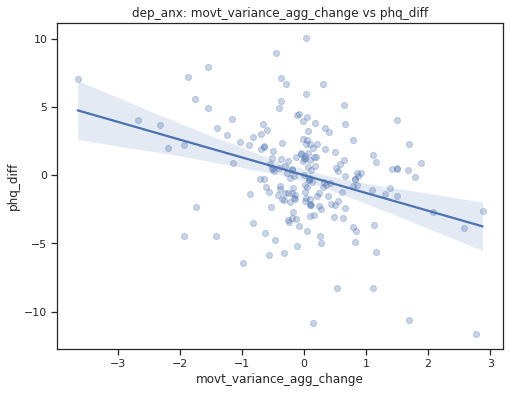

In [113]:
sel_state_df = phq_corr
ls_utils.plot_cluster_scatter('movt_variance_agg_change', 'phq_diff', sel_state_df, 'dep_anx', (8,6))

### Movement distance

In [108]:
ls_utils.build_corr_table(phq_corr, 'movt_distance_agg_change', agg_cols_change, 'phq_diff', 'movement distance change to PHQ change')

,group,n,r,p-corr,p-adjust
0,all,1073,-0.118,0.000240823,fdr_bh
1,no_symp,325,-0.135,0.118029,fdr_bh
2,soc_anx,292,-0.081,0.223641,fdr_bh
3,gen_anx,268,-0.204,0.00628099,fdr_bh
4,dep_anx,188,-0.183,0.0180978,fdr_bh


In [109]:
ls_utils.build_corr_table(rev_phq_corr, 'movt_distance_agg_change', agg_cols_change, 'phq_diff', 'PHQ change to movement distance change')

,group,n,r,p-corr,p-adjust
0,all,1072,0.013,0.954154,fdr_bh
1,no_symp,325,0.083,0.618613,fdr_bh
2,soc_anx,291,-0.043,0.746612,fdr_bh
3,gen_anx,266,-0.149,0.15777,fdr_bh
4,dep_anx,190,0.031,0.885044,fdr_bh


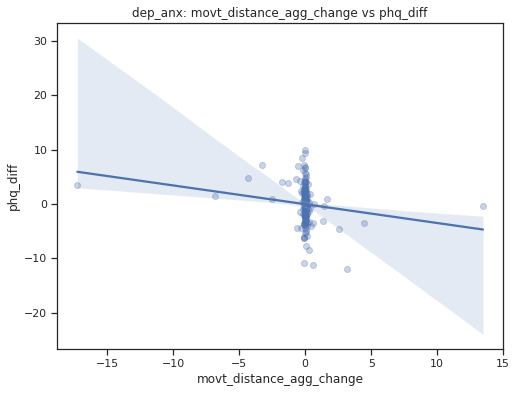

In [114]:
sel_state_df = phq_corr
ls_utils.plot_cluster_scatter('movt_distance_agg_change', 'phq_diff', sel_state_df, 'dep_anx', (8,6))

### Movement duration

In [110]:
ls_utils.build_corr_table(phq_corr, 'movt_duration_agg_change', agg_cols_change, 'phq_diff', 'movement duration change to PHQ change')

,group,n,r,p-corr,p-adjust
0,all,1073,-0.115,0.000337785,fdr_bh
1,no_symp,325,-0.045,0.590409,fdr_bh
2,soc_anx,292,-0.173,0.024475,fdr_bh
3,gen_anx,268,-0.064,0.442816,fdr_bh
4,dep_anx,188,-0.229,0.00349441,fdr_bh


In [111]:
ls_utils.build_corr_table(rev_phq_corr, 'movt_duration_agg_change', agg_cols_change, 'phq_diff', 'PHQ change to movement duration change')

,group,n,r,p-corr,p-adjust
0,all,1072,-0.002,0.954154,fdr_bh
1,no_symp,325,-0.048,0.618613,fdr_bh
2,soc_anx,291,0.043,0.746612,fdr_bh
3,gen_anx,266,0.032,0.839738,fdr_bh
4,dep_anx,190,-0.054,0.885044,fdr_bh


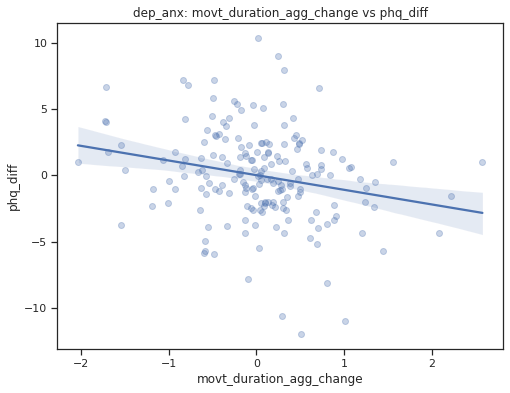

In [115]:
sel_state_df = phq_corr
ls_utils.plot_cluster_scatter('movt_duration_agg_change', 'phq_diff', sel_state_df, 'dep_anx', (8,6))